In this notebook, I detail the method by which a grid is generated and subsequently filled.

In [21]:
import pickle
import numpy as np
import torch
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.cuda.set_per_process_memory_fraction(0.9)
rtx = torch.device('cuda')
WEEKDAY_GRID_SIZE = 15
total_completed = 0


In [22]:
#  if a square is empty, 0.  If a square is black, 1.
def bin_gridify(raw_grids):
    binary_grids = []
    for grid in raw_grids:
        new_grid = [1 if x == "." else 0 for x in grid ]
        binary_grids = binary_grids + [new_grid]
    return binary_grids


In [23]:
dow_dict = pickle.load(open('../bin/pickles/dow_dict.pickle','rb'))

In [24]:
data_set = []
for day in dow_dict.keys():
    grid_list = dow_dict[day]
    grid_list = bin_gridify(grid_list)
    data_set = data_set + [grid_list]

In [25]:
import matplotlib.pyplot as plt

mon = data_set[0]
mon = [np.array(grid).reshape(15,15) for grid in mon if len(grid) == (15*15)]

tue = data_set[1]
tue = [np.array(grid).reshape(15,15) for grid in tue if len(grid) == (15*15)]

In [26]:
# defining a function that checks the symmetry of the grid
def check_symmetry(dim,grid):
    leng = dim*dim
    half = (leng-1)//2
    array = grid.reshape(leng,)
    front = array[:half]
    back = array[-half:]
    return (front == np.flip(back)).all()

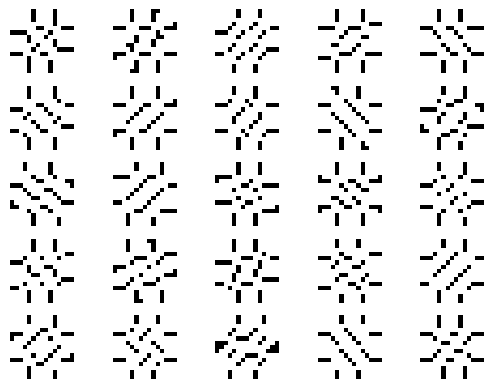

In [27]:
for i in range(25):
    plt.subplot(5,5,1+i)
    plt.axis('off')
    plt.imshow(mon[i],cmap="Greys")
plt.show()

In [28]:
# import torchvision
# from torchvision import datasets
# import torchvision.transforms as transforms
# print("PyTorch version is:",torch.__version__)
# print("Torchvision version is:",torchvision.__version__)


In [29]:
num_workers = 8 #
batch_size = 32 # number of samples per batch

train_data = np.array(mon+tue)
train_data_tensor = torch.from_numpy(train_data).float()
train_data_tensor = train_data_tensor.to(rtx)
labels = np.array([1]*len(train_data))
labels = torch.from_numpy(labels)
labels = labels.to(rtx)

# creating a loader to feed the models training data
train_me = torch.utils.data.DataLoader(train_data_tensor, batch_size=batch_size,num_workers=0)

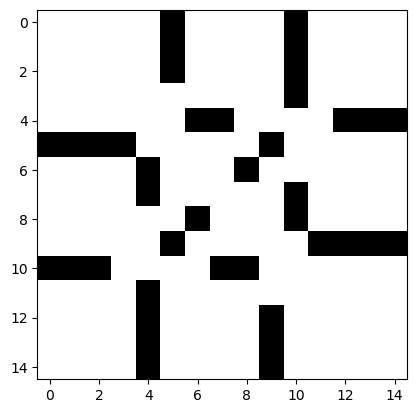

In [30]:
train_demo = iter(train_me)
images, *_ = train_demo.next()
img = np.squeeze(images[0:15])
fig = plt.imshow(img.cpu(),cmap='Greys',aspect=True)
# images.shape

## Creating custom class for the grid dataset in pytorch

In [31]:
import torch.nn as nn
import torch.nn.functional as F


class Discriminator(nn.Module):
    def __init__(self,input_size,hidden_dim,output_size):
        super(Discriminator,self).__init__()

        # 3 hidden layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4,hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2,hidden_dim)

        # output layer
        self.fc4 = nn.Linear(hidden_dim,output_size)

        # defining a dropout layer to prevent overfitting.
        self.dropout= nn.Dropout(0.4)

    def forward (self,x):
        x = x.view(-1,WEEKDAY_GRID_SIZE*WEEKDAY_GRID_SIZE)
        x = F.leaky_relu(self.fc1(x),0.01) # input
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.01)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.01)
        x = self.dropout(x)

        # return result of output layer
        return self.fc4(x)


In [32]:
# Defining a generator class
class Generator(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
         super(Generator, self).__init__()

         # Defining all hidden layers for the generator
         self.fc1 = nn.Linear(input_size, hidden_dim)
         self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
         self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)

         # Defining the output layer for the generator
         self.fc4 = nn.Linear(hidden_dim*4, output_size)

         # defining the droput for the generator, which prevents overfitting.
         self.dropout = nn.Dropout(0.2)
    def forward(self, x):
         # creating all hidden layers
         x = F.relu(self.fc1(x)) # (input, negative_slope=0.2)
         x = self.dropout(x) # dropout to reduce overfit
         x = F.relu(self.fc2(x))
         x = self.dropout(x)
         x = F.relu(self.fc3(x))
         x = self.dropout(x)

         # return result of the output layer
         return torch.tanh(self.fc4(x))


## Defining initial hyperparameters:

In [36]:
# discriminator
# size of the input grid
input_size = WEEKDAY_GRID_SIZE ** 2
# discriminator outputs either 1 or 0 depending on whether it sees a real or fake grid
discriminator_out_size = 1
# size of final hidden layer in discriminator
discriminator_hidden_size = 64

# generator
# size of the latent vector that is being passed to the generator
latent_vector_dim = 15
# size of the generator's output
generator_out_size = input_size
# size of the first hidden layer in the generator
generator_hidden_size = 32


## Creating the GAN:

In [37]:
# initializing the Gan with the above hyperparameters
discriminator = Discriminator(input_size,discriminator_hidden_size,discriminator_out_size)
generator = Generator(latent_vector_dim,generator_hidden_size,generator_out_size)

In [38]:
print("The Discriminator: \n",discriminator)
print("The Generator: \n", generator)

The Discriminator: 
 Discriminator(
  (fc1): Linear(in_features=225, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
The Generator: 
 Generator(
  (fc1): Linear(in_features=15, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=225, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## Defining Loss functions

In [39]:
# Calculating loss for the Discriminator
def discriminator_loss(disc_out, smooth=False):
    batch_size = disc_out.size(0)
    if smooth:
        # labels multiplied by 0.9
        labels = torch.ones(batch_size) * 0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1

    loss = nn.BCEWithLogitsLoss()
    return loss(disc_out.squeeze(),labels)


def generator_loss(disc_out):
    batch_size = disc_out.size(0)
    labels = torch.zeros(batch_size)
    loss = nn.BCEWithLogitsLoss()
    return loss(disc_out.squeeze(),labels)

## Defining optimizers:


In [40]:
from torch.optim import Adam

learning_rate = 0.002
discriminator_opt = Adam(discriminator.parameters(),learning_rate*2)
generator_opt = Adam(generator.parameters(),learning_rate)

## Training the models

In [41]:
import pickle as pkl

# parameters for training
num_epochs = 50

# list of sample set and fake set
sample_list = []
loss_list = []

print_every = 400

# generate some fixed data that can be used to benchmark the model throughout training
sample_size = 64
fixed_data = np.random.binomial(1,p=0.3,size=(sample_size,WEEKDAY_GRID_SIZE))
fixed_data = fixed_data * 2 - 1
fixed_data = torch.from_numpy(fixed_data).float()
fixed_data = fixed_data.to(rtx)


# setup the dataloader

train_me = torch.utils.data.DataLoader(dataset=train_data_tensor, batch_size=batch_size,num_workers=0,drop_last=True)


In [42]:
import os
os.environ['CUDA_LAUNCH_BLOCKING']= "0"

from torch import multiprocessing

Epoch [  651/  950] | Discriminator Loss: 1.0718 | Generator Loss: 1.4516
Epoch 651 was completed in 0.5803181762695313 seconds
Epoch [  652/  950] | Discriminator Loss: 0.8801 | Generator Loss: 2.0108
Epoch 652 was completed in 0.5122129516601562 seconds
Epoch [  653/  950] | Discriminator Loss: 0.9667 | Generator Loss: 1.4343
Epoch 653 was completed in 0.4634723815917969 seconds
Epoch [  654/  950] | Discriminator Loss: 1.3071 | Generator Loss: 1.5677
Epoch 654 was completed in 0.47597738647460935 seconds
Epoch [  655/  950] | Discriminator Loss: 0.8799 | Generator Loss: 1.4211
Epoch 655 was completed in 0.468177978515625 seconds
Epoch [  656/  950] | Discriminator Loss: 1.1433 | Generator Loss: 1.2546
Epoch 656 was completed in 0.5687163696289063 seconds
Epoch [  657/  950] | Discriminator Loss: 1.0096 | Generator Loss: 1.4092
Epoch 657 was completed in 0.5365704345703125 seconds
Epoch [  658/  950] | Discriminator Loss: 0.8948 | Generator Loss: 1.4421
Epoch 658 was completed in 0.4

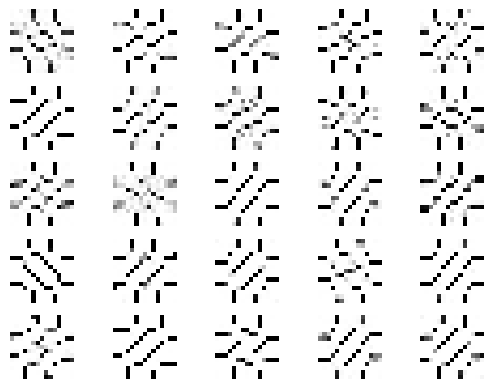

In [53]:
# Training time!
import random
num_epochs = 300
discriminator.train()
generator.train()
init_total_completed = total_completed
for epoch in range(num_epochs):
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()

    for b_index, real_grids in enumerate(train_me):

        # get batch size from size of real_grids
        batch_size = real_grids.size(0)

        real_grids = real_grids*2-1 # rescale input images from [0,1] to [-1,1]

        # DISC Training
        discriminator_opt.zero_grad(set_to_none=True)



        # first, train on real images
        disc_real = discriminator(real_grids)
        disc_real_loss = discriminator_loss(disc_real,smooth=False)

        # next, to train on fake images
        # start by generating fake images
        fake_grid_input = np.random.binomial(1,p=0.3,size=(batch_size,WEEKDAY_GRID_SIZE,WEEKDAY_GRID_SIZE))
        fake_grid_input = fake_grid_input*2-1
        fake_grid_input = torch.from_numpy(fake_grid_input).float()
        fake_grid_input =fake_grid_input.to(rtx)
        fake_grids = generator(fake_grid_input)

        # Compute the disc loss on the fake images
        disc_fake = discriminator(fake_grids)
        disc_fake_loss = generator_loss(disc_fake)

        # sum the losses
        disc_loss = disc_real_loss + disc_fake_loss

        # backpropagation
        disc_loss.backward()
        discriminator_opt.step()


        ### Generator Training
        generator_opt.zero_grad(set_to_none=True)

        # train on fake images with flipped labels
        # first, generate fake images
        fake_grid_input = np.random.binomial(1,p=0.4,size=(batch_size,WEEKDAY_GRID_SIZE,WEEKDAY_GRID_SIZE))
        fake_grid_input = fake_grid_input*2-1
        fake_grid_input = torch.from_numpy(fake_grid_input).float()
        fake_grid_input = fake_grid_input.to(rtx)
        fake_grids = generator(fake_grid_input)

        # compute the discriminator losses on fake images, and flip the labels by using the disc_loss function
        disc_fake = discriminator(fake_grids)
        gen_loss = discriminator_loss(disc_fake)

        # backpropagation
        gen_loss.backward()
        generator_opt.step()

        # Log progress to stdout
        # if b_index % print_every==0:
        #
        #     # print discriminator and generator loss
        #     print('Epoch [{:5d}/{:5d}] | Discriminator Loss: {:6.4f} | Generator Loss: {:6.4f}'.format(epoch+1, num_epochs,
        #                                                                            disc_loss.item(), gen_loss.item()))

    end_event.record()
    torch.cuda.synchronize()  # Wait for the events to be recorded!
    elapsed_time_ms = start_event.elapsed_time(end_event)
    total_completed = total_completed +1
    print('Epoch [{:5d}/{:5d}] | Discriminator Loss: {:6.4f} | Generator Loss: {:6.4f}'.format(total_completed, init_total_completed  + num_epochs,
                                                                                   disc_loss.item(), gen_loss.item()))
    print(f'Epoch {total_completed} was completed in {elapsed_time_ms/1000} seconds')
    ## Append discriminator loss and gen loss after each epoch
    loss_list.append((disc_loss.item(),gen_loss.item()))

    # generate images with generator and save image
    # set generator in eval mode
    generator.eval()

    #generate samples
    new_samples = generator(fixed_data)
    new_samples_detached = [sample.detach().cpu().numpy() for sample in new_samples]
    sample_list.append(new_samples)

    sample_sample = random.sample(new_samples_detached,25)

    # print the image
    for i in range(25):
        plt.subplot(5,5,1+i)
        plt.axis('off')
        plt.imshow(new_samples_detached[i].reshape(15,15),cmap="Greys")
    plt.savefig(f'../exports/gridgan-images/generation_{str.zfill(str(total_completed),4)}.png',)

    if total_completed % 10 == 0:
        torch.cuda.empty_cache()
    # return generator to training mode
    generator.train()

with open('../bin/train_samples.pickle','wb') as f:
    pkl.dump(sample_list,f)

with open('../bin/gan_model_tuple.pickle','wb') as f:
    pkl.dump((discriminator,generator),f)